In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
!python -m spacy download fr_core_news_md -qq
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import fr_core_news_md
from PyPDF2 import PdfFileReader
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [4]:
# def get_documents(path):
#   """
#   Extract text from a PDF file.
#   """
#   dataset = []
#   for file in os.listdir(path):
#     if file.endswith('.pdf'):
#       pdf_file = open(path + '/' + file, 'rb')
#       pdf = PdfFleReader(pdf_file)
#       text = ""
#       for page in pdf.pages:
#           text += page.extract_text()
      
#       row = [pdf.metadata.title, text]
#     dataset.append(row)
#   df = pd.DataFrame(dataset, columns=['title', 'text'])
#   return df


# df = get_documents('../docs')
# df.head()

[Project link here](https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf)

### 1. Collecte des données

In [5]:
def get_documents(path):
  """
  Extract text from a PDF file.
  """
  dataset = []
  for file in os.listdir(path):
    if file.endswith('.pdf'):
      pdf_file = open(path + '/' + file, 'rb')
      pdf = PdfFileReader(pdf_file)
      page = pdf.pages[-1]
      if file == 'BEA2016-0759.pdf':
        text = page.extract_text()
        text = text.split('Conclusion')[1]
      elif file == 'n-ca001215_05.pdf':
        # La section Conclusion est à l'avant dernière page
        # contrairement aux 2 autres documents
        text = ""
        # page = pdf.pages[-1]
        # text =  page.extract_text()
        # print(text)
        # text = text.split('Conclusion')[1]
        
      elif file == 'n-tg000906_06.pdf':
        text = page.extract_text()
        text = text.split('CONCLUSION')[1]
       
      row = [str(file), text]
    dataset.append(row)
  df = pd.DataFrame(dataset, columns=['PDF', 'Content'])
  return df


df = get_documents('../docs')
df.head()

c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\PyPDF2\_reader.py:1360: PdfReadWarning: Xref table not zero-indexed. ID numbers for objects will be corrected.
  warnings.warn(
c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\PyPDF2\_page.py:1238: PdfReadWarning:  impossible to decode XFormObject /Im0
  warnings.warn(


,PDF,Content
0,BEA2016-0759.pdf,\n\n\nLe pilote s’est désaxé de la trajectoire...
1,n-ca001215_05.pdf,
2,n-tg000906_06.pdf,\n\n\nL’accident résulte d’une décision inappr...


In [6]:
df['Content'][2]

'\n\n\nL’accident résulte d’une décision inappropriée de l’équipage dans le choix \n\n\ndu/uni00A0cheminement utilisé pour réaliser un largage de barrage. Ce choix a probablement \n\n\nété dicté par le fait que le copilote, pilote en fonction, pouvait mieux contrôler de sa \n\n\nplace, notamment, le virage à droite sur la ville de Burzet. L’évolution à proximité \n\n\ndu relief était inadaptée pour un avion de ce gabarit et nécessitait de la part de \n\n\nl’équipage un pilotage aux limites du domaine de vol. La dernière phase de vol, \n\n\nréalisée sans doute au second régime de vol, n’a pas permis au pilote de reprendre \n\n\nsuffisamment de hauteur pour s’affranchir du relief. La charge de travail du copilote, \n\n\npilote en fonction, ne lui a pas laissé le temps d’exécuter un largage d’urgence pour \n\n\nalléger l’avion et dégager dans la vallée. Le soleil de face et la présence de fumée \n\n\ndans la dernière ligne droite ont amené l’équipage à faire une appréciation erronée \n\n\

### 2. Processer les données

In [7]:
# Notre modèle spqcy:
nlp = fr_core_news_md.load()
# Tages à supprimer du text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(df['Content']):
   report_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(report_tok)

df['tokens'] = tokens
df['tokens']

c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\catalogue\__ini

0    [pilote, désaxé, trajectoire, approche, instru...
1                                                   []
2    [accident, résulte, décision, inapproprié, équ...
Name: tokens, dtype: object

## 3. Creation du dictionnaire et du corpus

### Creation du dictionnary

In [8]:
dictionary = Dictionary(df['tokens'])
# dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
print(dictionary.token2id)

{'accident': 0, 'acquérir': 1, 'altitude': 2, 'approche': 3, 'autoroute': 4, 'avion': 5, 'axe': 6, 'baser': 7, 'bord': 8, 'cohérence': 9, 'compte': 10, 'condition': 11, 'conduire': 12, 'confusion': 13, 'contrôle': 14, 'cours': 15, 'difficile': 16, 'débuter': 17, 'décision': 18, 'désaxé': 19, 'erroné': 20, 'extérieur': 21, 'fonder': 22, 'ft': 23, 'gauche': 24, 'gaz': 25, 'guidage': 26, 'illustre': 27, 'imc': 28, 'importance': 29, 'incohérence': 30, 'information': 31, 'instrument': 32, 'interrompre': 33, 'issu': 34, 'maintenir': 35, 'manœuvre': 36, 'marginal': 37, 'perdre': 38, 'phase': 39, 'pilote': 40, 'précis': 41, 'remise': 42, 'rendre': 43, 'référence': 44, 'situer': 45, 'suivre': 46, 'surveillance': 47, 'trajectoire': 48, 'transition': 49, 'visuel': 50, 'vue': 51, 'affranchir': 52, 'alléger': 53, 'amener': 54, 'appréciation': 55, 'azimut': 56, 'barrage': 57, 'burzet': 58, 'charge': 59, 'choix': 60, 'constituer': 61, 'contrôler': 62, 'copilote': 63, 'dernier': 64, 'dicter': 65, 'dom

### Création de notre corpus

In [16]:
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=3, workers = 4, passes=10)

## 4. Création du modèle

## Calcul du score de cohérence à l'aide de $C_{umass}$ :

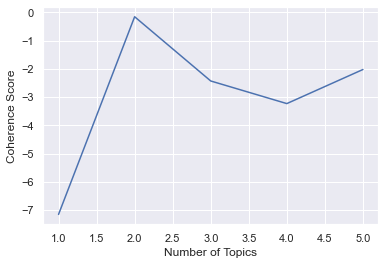

In [17]:
topics = []
score = []
for i in range(1,6,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

## Calculating the coherence score using $C_v$:

c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


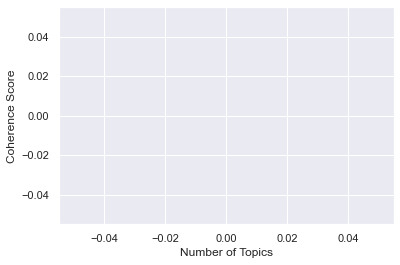

In [18]:
topics = []
score = []
for i in range(1,6,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [19]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=20, num_topics=2, workers = 4, passes=100)

## 5. Visualisation of topics

In [20]:
lda_model.print_topics(-1)

[(0,
  '0.030*"approche" + 0.026*"pilote" + 0.021*"vol" + 0.021*"dernier" + 0.021*"instrument" + 0.016*"largage" + 0.016*"relief" + 0.016*"équipage" + 0.016*"avion" + 0.016*"accident"'),
 (1,
  '0.009*"approche" + 0.009*"instrument" + 0.009*"extérieur" + 0.009*"condition" + 0.009*"référence" + 0.009*"cours" + 0.009*"visuel" + 0.009*"incohérence" + 0.009*"manœuvre" + 0.009*"remise"')]

Visualisation les sujets et les mots associés à chaque sujet:

In [14]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
# pyLDAvis.display(lda_display)

c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [15]:
# pyLDAvis.save_html(lda_display, 'index.html')